In [1]:
using Revise
using HierarchicalDA
using LinearAlgebra
using OrdinaryDiffEq
using Trixi
using FFTW
using DifferentialEquations

Precompiling HierarchicalDA
  ✓ HierarchicalDA
  1 dependency successfully precompiled in 10 seconds. 528 already precompiled.


In [13]:
using CairoMakie
using LaTeXStrings
# using Plots

In [44]:
using OrdinaryDiffEq
using Trixi

###############################################################################
# Semidiscretization of the shallow water equations

equations = ShallowWaterEquations1D(gravity_constant = 9.81)

initial_condition = initial_condition_convergence_test

boundary_condition = BoundaryConditionDirichlet(initial_condition)

###############################################################################
# Get the DG approximation space

volume_flux = (flux_wintermeyer_etal, flux_nonconservative_wintermeyer_etal)
surface_flux = (flux_lax_friedrichs, flux_nonconservative_fjordholm_etal)
# solver = DGSEM(polydeg = 3, )

basis = DGMultiBasis(Line(), polydeg, approximation_type = GaussSBP())



dg = DGMulti(basis,
             surface_integral = SurfaceIntegralWeakForm(surface_flux),
             volume_integral = VolumeIntegralFluxDifferencing(volume_flux))

###############################################################################
# Get the TreeMesh and setup a periodic mesh

# coordinates_min = 0.0
# coordinates_max = sqrt(2.0)
# mesh = TreeMesh(coordinates_min, coordinates_max,
#                 initial_refinement_level = 3,
#                 n_cells_max = 10_000,
#                 periodicity = false)
cells_per_dimension = (64,)
mesh = DGMultiMesh(dg, cells_per_dimension,
                   coordinates_min = (0.0,), coordinates_max = (sqrt(2.0),),
                   periodicity = true)


# create the semi discretization object
semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, solver,
                                    boundary_conditions = boundary_condition,
                                    source_terms = source_terms_convergence_test)

###############################################################################
# ODE solvers, callbacks etc.

tspan = (0.0, 1.0)
ode = semidiscretize(semi, tspan)

summary_callback = SummaryCallback()

analysis_interval = 500
analysis_callback = AnalysisCallback(semi, interval = analysis_interval)

alive_callback = AliveCallback(analysis_interval = analysis_interval)

save_solution = SaveSolutionCallback(interval = 200,
                                     save_initial_solution = true,
                                     save_final_solution = true)

callbacks = CallbackSet(summary_callback, analysis_callback, alive_callback, save_solution)

###############################################################################
# run the simulation

# use a Runge-Kutta method with automatic (error based) time step size control
sol = solve(ode, RDPK3SpFSAL49(); abstol = 1.0e-8, reltol = 1.0e-8, callback = callbacks);
summary_callback() # print the timer summary

LoadError: MethodError: no method matching create_cache(::DGMultiMesh{1, Trixi.Affine, StartUpDG.MeshData{1, StartUpDG.VertexMappedMesh{Line, Tuple{Vector{Float64}}, Matrix{Int64}}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Int64}, Matrix{Float64}, StaticArraysCore.SMatrix{1, 1, Matrix{Float64}, 1}, Matrix{Float64}, Matrix{Int64}, Matrix{Int64}, Vector{Matrix{Float64}}}, Dict{Symbol, Vector{Int64}}}, ::ShallowWaterEquations1D{Float64}, ::DGSEM{LobattoLegendreBasis{Float64, 4, SVector{4, Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}}, Trixi.LobattoLegendreMortarL2{Float64, 4, Matrix{Float64}, Matrix{Float64}}, SurfaceIntegralWeakForm{Tuple{FluxLaxFriedrichs{typeof(max_abs_speed_naive)}, typeof(flux_nonconservative_fjordholm_etal)}}, VolumeIntegralFluxDifferencing{Tuple{typeof(flux_wintermeyer_etal), typeof(flux_nonconservative_wintermeyer_etal)}}}, ::Type{Float64}, ::Type{Float64})

[0mClosest candidates are:
[0m  create_cache(::Any, ::Any, ::Any, ::Any, ::Any, [91m::Any[39m)
[0m[90m   @[39m [35mTrixi[39m [90m~/.julia/packages/Trixi/kZ2a3/src/solvers/dgmulti/[39m[90m[4mflux_differencing_gauss_sbp.jl:442[24m[39m
[0m  create_cache(::Any, ::Any, [91m::VolumeIntegralWeakForm[39m, ::Any, ::Any)
[0m[90m   @[39m [35mTrixi[39m [90m~/.julia/packages/Trixi/kZ2a3/src/solvers/[39m[90m[4mdg.jl:51[24m[39m
[0m  create_cache([91m::TreeMesh{3, TreeType} where TreeType<:Trixi.AbstractTree{3}[39m, ::Any, ::DG, ::Any, ::Any)
[0m[90m   @[39m [35mTrixi[39m [90m~/.julia/packages/Trixi/kZ2a3/src/solvers/dgsem_tree/[39m[90m[4mdg_3d.jl:14[24m[39m
[0m  ...


In [41]:
# equations = InviscidBurgersEquation1D()
equations = ShallowWaterEquations1D(gravity_constant = 9.812, H0 = 1.75)


###############################################################################
# setup the GSBP DG discretization that uses the Gauss operators from 
# Chan, Del Rey Fernandez, Carpenter (2019). 
# [https://doi.org/10.1137/18M1209234](https://doi.org/10.1137/18M1209234)

# surface_flux = flux_lax_friedrichs
# volume_flux = flux_fjordholm_etal

equations = ShallowWaterEquations1D(gravity_constant = 9.81)

initial_condition = initial_condition_convergence_test

boundary_condition = BoundaryConditionDirichlet(initial_condition)

###############################################################################
# Get the DG approximation space

volume_flux = (flux_wintermeyer_etal, flux_nonconservative_wintermeyer_etal)
surface_flux = (flux_lax_friedrichs, flux_nonconservative_fjordholm_etal)

polydeg = 3
basis = DGMultiBasis(Line(), polydeg, approximation_type = GaussSBP())

# # indicator_sc = IndicatorHennemannGassner(equations, basis,
#                                          alpha_max = 0.5,
#                                          alpha_min = 0.001,
#                                          alpha_smooth = true,
#                                          variable = first)
# volume_integral = VolumeIntegralShockCapturingHG(indicator_sc;
#                                                  volume_flux_dg = volume_flux,
#                                                  volume_flux_fv = surface_flux)

dg = DGMulti(basis,
             surface_integral = surface_flux,
             volume_integral = VolumeIntegralFluxDifferencing(volume_flux))

###############################################################################
#  setup the 1D mesh

cells_per_dimension = (32,)
mesh = DGMultiMesh(dg, cells_per_dimension,
                   coordinates_min = (-1.0,), coordinates_max = (1.0,),
                   periodicity = false)

###############################################################################
#  setup the semidiscretization and ODE problem

semi = SemidiscretizationHyperbolic(mesh,
                                    equations,
                                    initial_condition_convergence_test,
                                    dg, boundary_conditions = boundary_condition)

tspan = (0.0, 2.0)
ode = semidiscretize(semi, tspan)

###############################################################################
#  setup the callbacks

# prints a summary of the simulation setup and resets the timers
summary_callback = SummaryCallback()

# analyse the solution in regular intervals and prints the results
analysis_callback = AnalysisCallback(semi, interval = 100, uEltype = real(dg))

# handles the re-calculation of the maximum Δt after each time step
stepsize_callback = StepsizeCallback(cfl = 0.5)

# collect all callbacks such that they can be passed to the ODE solver
callbacks = CallbackSet(summary_callback, analysis_callback, stepsize_callback)

# ###############################################################################
# # run the simulation

sol = solve(ode, CarpenterKennedy2N54(williamson_condition = false),
            dt = 1.0, save_everystep = false, callback = callbacks);


LoadError: MethodError: no method matching create_cache(::DGMultiMesh{1, Trixi.Affine, StartUpDG.MeshData{1, StartUpDG.VertexMappedMesh{Line, Tuple{Vector{Float64}}, Matrix{Int64}}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Int64}, Matrix{Float64}, StaticArraysCore.SMatrix{1, 1, Matrix{Float64}, 1}, Matrix{Float64}, Matrix{Int64}, Matrix{Int64}, Vector{Matrix{Float64}}}, Dict{Symbol, Vector{Int64}}}, ::ShallowWaterEquations1D{Float64}, ::DGMulti{1, Line, Polynomial{Gauss}, Tuple{FluxLaxFriedrichs{typeof(max_abs_speed_naive)}, typeof(flux_nonconservative_fjordholm_etal)}, VolumeIntegralFluxDifferencing{Tuple{typeof(flux_wintermeyer_etal), typeof(flux_nonconservative_wintermeyer_etal)}}, Nothing, StartUpDG.RefElemData{1, Line, Polynomial{Gauss}, Int64, Tuple{Int64, Int64}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Vector{Int64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Tuple{Matrix{Float64}}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Vector{Float64}, Vector{Float64}}}, ::Type{Float64}, ::Type{Float64})

[0mClosest candidates are:
[0m  create_cache(::Any, ::Any, ::Any, ::Any, ::Any, [91m::Any[39m)
[0m[90m   @[39m [35mTrixi[39m [90m~/.julia/packages/Trixi/kZ2a3/src/solvers/dgmulti/[39m[90m[4mflux_differencing_gauss_sbp.jl:442[24m[39m
[0m  create_cache(::Any, ::Any, [91m::VolumeIntegralWeakForm[39m, ::Any, ::Any)
[0m[90m   @[39m [35mTrixi[39m [90m~/.julia/packages/Trixi/kZ2a3/src/solvers/[39m[90m[4mdg.jl:51[24m[39m
[0m  create_cache([91m::TreeMesh{3, TreeType} where TreeType<:Trixi.AbstractTree{3}[39m, ::Any, ::DG, ::Any, ::Any)
[0m[90m   @[39m [35mTrixi[39m [90m~/.julia/packages/Trixi/kZ2a3/src/solvers/dgsem_tree/[39m[90m[4mdg_3d.jl:14[24m[39m
[0m  ...


In [37]:
###############################################################################
# Semidiscretization of the shallow water equations

equations = ShallowWaterEquations1D(gravity_constant = 9.812, H0 = 1.75)

# Initial condition with a truly discontinuous velocity and bottom topography.
# Works as intended for TreeMesh1D with `initial_refinement_level=3`. If the mesh
# refinement level is changed the initial condition below may need changed as well to
# ensure that the discontinuities lie on an element interface.
function initial_condition_stone_throw_discontinuous_bottom(x, t,
                                                            equations::ShallowWaterEquations1D)

    # Calculate primitive variables

    # flat lake
    H = equations.H0

    # Discontinuous velocity
    v = 0.0
    if x[1] >= -0.75 && x[1] <= 0.0
        v = -1.0
    elseif x[1] >= 0.0 && x[1] <= 0.75
        v = 1.0
    end

    b = (1.5 / exp(0.5 * ((x[1] - 1.0)^2)) +
         0.75 / exp(0.5 * ((x[1] + 1.0)^2)))

    # Force a discontinuous bottom topography
    if x[1] >= -1.5 && x[1] <= 0.0
        b = 0.5
    end

    return prim2cons(SVector(H, v, b), equations)
end

initial_condition = initial_condition_stone_throw_discontinuous_bottom

boundary_condition = boundary_condition_slip_wall

###############################################################################
# Get the DG approximation space

volume_flux = (flux_wintermeyer_etal, flux_nonconservative_wintermeyer_etal)
surface_flux = (FluxHydrostaticReconstruction(flux_lax_friedrichs,
                                              hydrostatic_reconstruction_audusse_etal),
                flux_nonconservative_audusse_etal)
# basis = LobattoLegendreBasis(4)
polydeg = 3
basis = DGMultiBasis(Line(), polydeg, approximation_type = GaussSBP())

indicator_sc = IndicatorHennemannGassner(equations, basis,
                                         alpha_max = 0.5,
                                         alpha_min = 0.001,
                                         alpha_smooth = true,
                                         variable = waterheight_pressure)
volume_integral = VolumeIntegralShockCapturingHG(indicator_sc;
                                                 volume_flux_dg = volume_flux,
                                                 volume_flux_fv = surface_flux)

dg = DGMulti(basis, surface_flux, volume_integral)

# solver = DGSEM(basis, surface_flux, volume_integral)

###############################################################################
# Create the TreeMesh for the domain [-3, 3]

# coordinates_min = -3.0
# coordinates_max = 3.0
# mesh = TreeMesh(coordinates_min, coordinates_max,
#                 initial_refinement_level = 3,
#                 n_cells_max = 10_000,
#                 periodicity = false)

cells_per_dimension = (64,)
mesh = DGMultiMesh(dg, cells_per_dimension,
                   coordinates_min = (-3.0,), coordinates_max = (3.0,),
                   periodicity = false)

# create the semi discretization object
semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, solver,
                                    boundary_conditions = boundary_condition)

###############################################################################
# ODE solver

tspan = (0.0, 3.0)
ode = semidiscretize(semi, tspan)

###############################################################################
# Callbacks

summary_callback = SummaryCallback()

analysis_interval = 100
analysis_callback = AnalysisCallback(semi, interval = analysis_interval,
                                     save_analysis = false,
                                     extra_analysis_integrals = (energy_kinetic,
                                                                 energy_internal,
                                                                 lake_at_rest_error))

# Enable in-situ visualization with a new plot generated every 50 time steps
# and we explicitly pass that the plot data will be one-dimensional
# visualization = VisualizationCallback(interval=50, plot_data_creator=PlotData1D)

alive_callback = AliveCallback(analysis_interval = analysis_interval)

save_solution = SaveSolutionCallback(interval = 100,
                                     save_initial_solution = true,
                                     save_final_solution = true)

callbacks = CallbackSet(summary_callback, analysis_callback, alive_callback, save_solution)#,
# visualization)

###############################################################################
# run the simulation

# use a Runge-Kutta method with automatic (error based) time step size control
sol = solve(ode, RDPK3SpFSAL49(); abstol = 1.0e-7, reltol = 1.0e-7, callback = callbacks);
summary_callback() # print the timer summary

LoadError: MethodError: no method matching (DGMulti{NDIMS, ElemType, ApproxType} where {NDIMS, ElemType, ApproxType})(::StartUpDG.RefElemData{1, Line, Polynomial{Gauss}, Int64, Tuple{Int64, Int64}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Vector{Int64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Tuple{Matrix{Float64}}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Vector{Float64}, Vector{Float64}}, ::Tuple{FluxHydrostaticReconstruction{FluxLaxFriedrichs{typeof(max_abs_speed_naive)}, typeof(hydrostatic_reconstruction_audusse_etal)}, typeof(flux_nonconservative_audusse_etal)}, ::VolumeIntegralShockCapturingHG{Tuple{typeof(flux_wintermeyer_etal), typeof(flux_nonconservative_wintermeyer_etal)}, Tuple{FluxHydrostaticReconstruction{FluxLaxFriedrichs{typeof(max_abs_speed_naive)}, typeof(hydrostatic_reconstruction_audusse_etal)}, typeof(flux_nonconservative_audusse_etal)}, IndicatorHennemannGassner{Float64, typeof(waterheight_pressure), @NamedTuple{alpha::Vector{Float64}, alpha_tmp::Vector{Float64}, indicator_threaded::Vector{Vector{Float64}}, modal_threaded::Vector{Vector{Float64}}, inverse_vandermonde::Trixi.SimpleKronecker{1, Matrix{Float64}, Vector{Vector{Float64}}}}}})

[0mClosest candidates are:
[0m  (DGMulti{NDIMS, ElemType, ApproxType} where {NDIMS, ElemType, ApproxType})([91m::Wedge[39m, ::Any, ::Any, [91m::Any[39m; polydeg, kwargs...)
[0m[90m   @[39m [35mTrixi[39m [90m~/.julia/packages/Trixi/kZ2a3/src/solvers/dgmulti/[39m[90m[4mtypes.jl:97[24m[39m
[0m  (DGMulti{NDIMS, ElemType, ApproxType} where {NDIMS, ElemType, ApproxType})([91m::NodesAndModes.AbstractElemShape[39m, ::Any, ::Any, [91m::Any[39m; polydeg, kwargs...)
[0m[90m   @[39m [35mTrixi[39m [90m~/.julia/packages/Trixi/kZ2a3/src/solvers/dgmulti/[39m[90m[4mtypes.jl:112[24m[39m
[0m  (DGMulti{NDIMS, ElemType, ApproxType} where {NDIMS, ElemType, ApproxType})([91m::NodesAndModes.AbstractElemShape[39m, [91m::SummationByPartsOperators.AbstractDerivativeOperator[39m, ::Any, [91m::Any[39m; kwargs...)
[0m[90m   @[39m [35mTrixi[39m [90m~/.julia/packages/Trixi/kZ2a3/src/solvers/dgmulti/[39m[90m[4msbp.jl:30[24m[39m
[0m  ...


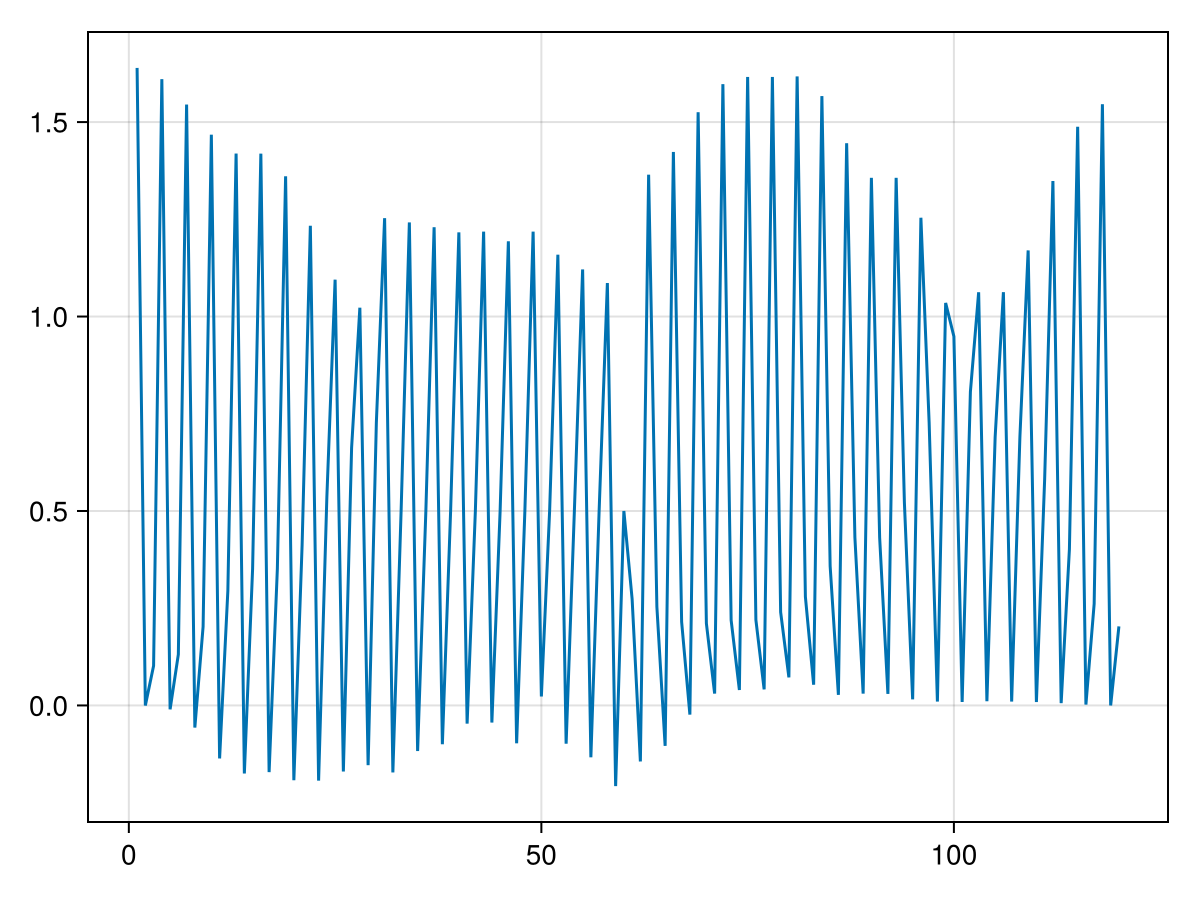

In [34]:
lines(sol(2.0))

In [28]:
vec(sol(0.1))

40-element Vector{SVector{4, Float64}}:
 [1.925103959972385, 0.48133177883595113, 0.19999999999999993, 1.1000000000000003]
 [2.0053431111578526, 0.501312095059157, 0.19323990719294726, 1.099081807517627]
 [2.144798403722367, 0.536218177338138, 0.1808658283817455, 1.0923879532511274]
 [2.2580313512398615, 0.5644891448676054, 0.16974939847135012, 1.0796216329185693]
 [2.3039928824949616, 0.5760471048477851, 0.16464466094067262, 1.0707106781186535]
 [2.3040076603567297, 0.5760268629028911, 0.16464466094067262, 1.0707106781186535]
 [2.339178270700519, 0.5847802913090355, 0.16018918354071537, 1.0605012030572987]
 [2.37423332740933, 0.5935673979072453, 0.15380602337443564, 1.038268343236507]
 [2.367307871500823, 0.5918196012768204, 0.15045909624118625, 1.0135201856141038]
 [2.3474944174502306, 0.5869098573367705, 0.1499999999999996, 0.9999999999999987]
 [2.3474970963514443, 0.5868623340351674, 0.1499999999999996, 0.9999999999999987]
 [2.3174620461071416, 0.5793702527014979, 0.150459096241186

In [15]:
equations = ShallowWaterEquations1D(gravity_constant = 9.81)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ ShallowWaterEquations1D                                                                          │
│ ═══════════════════════                                                                          │
│ #variables: ………………………………………………… 3                                                                │
│ │ variable 1: …………………………………………… h                                                                │
│ │ variable 2: …………………………………………… h_v                                                              │
│ │ variable 3: …………………………………………… b                                                                │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

In [16]:
initial_condition = initial_condition_convergence_test

initial_condition_convergence_test (generic function with 24 methods)

In [17]:
volume_flux = (flux_chan_etal, flux_nonconservative_chan_etal)
surface_flux = (FluxPlusDissipation(flux_chan_etal, DissipationLocalLaxFriedrichs()),
                flux_nonconservative_chan_etal)

dg = DGMulti(polydeg = 4, element_type = Line(), approximation_type = GaussSBP(),
             surface_integral = SurfaceIntegralWeakForm(surface_flux),
             volume_integral = VolumeIntegralFluxDifferencing(volume_flux))

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DG{Float64}                                                                                      │
│ ═══════════                                                                                      │
│ basis: ……………………………………………………………… RefElemData{N=4, Polynomial{Gauss}, Line}.                       │
│ mortar: …………………………………………………………… nothing                                                          │
│ surface integral: ………………………………… SurfaceIntegralWeakForm                                          │
│ │ surface flux: ……………………………………… (FluxPlusDissipation(flux_chan_e…flux_nonconservative_chan_etal) │
│ volume integral: …………………………………… VolumeIntegralFluxDifferencing                                   │
│ │ volume flux: ………………………………………… (Trixi.flux_chan_etal, Trixi.flux_nonconservative_chan_etal)     │
└──────────────────────────────────────────────────────────────────────────────────────────

In [18]:
cells_per_dimension = (8,)
mesh = DGMultiMesh(dg, cells_per_dimension,
                   coordinates_min = (0.0,), coordinates_max = (sqrt(2),),
                   periodicity = true)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DGMultiMesh{1, Trixi.Affine},                                                                    │
│ ══════════════════════════════                                                                   │
│ number of elements: …………………………… 8                                                                │
│ number of boundaries: ……………………… 1                                                                │
│ │ nfaces on entire_boundary: …… 0                                                                │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

In [19]:
semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, dg)#;
#                                     source_terms = source_terms_convergence_test)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… Trixi.Affine DGMultiMesh with NDIMS = 1.                         │
│ equations: …………………………………………………… ShallowWaterEquations1D                                          │
│ initial condition: ……………………………… initial_condition_convergence_test                               │
│ boundary conditions: ………………………… Trixi.BoundaryConditionPeriodic                                  │
│ source terms: …………………………………………… nothing                                                          │
│ solver: …………………………………………………………… DG                                                       

In [14]:
using OrdinaryDiffEq
using Trixi

###############################################################################
# Semidiscretization of the quasi 1d shallow water equations
# See Chan et al.  https://doi.org/10.48550/arXiv.2307.12089 for details


initial_condition = initial_condition_convergence_test






###############################################################################
# ODE solvers, callbacks etc.

# tspan = (0.0, 1.0)
# ode = semidiscretize(semi, tspan)

# summary_callback = SummaryCallback()

# analysis_interval = 100
# analysis_callback = AnalysisCallback(semi, interval = analysis_interval, uEltype = real(dg))

# alive_callback = AliveCallback(analysis_interval = analysis_interval)

# callbacks = CallbackSet(summary_callback,
#                         analysis_callback,
#                         alive_callback)

# ###############################################################################
# # run the simulation

# sol = solve(ode, RDPK3SpFSAL49(); abstol = 1.0e-8, reltol = 1.0e-8,
#             ode_default_options()..., callback = callbacks)
# summary_callback() # print the timer summary

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… Trixi.Affine DGMultiMesh with NDIMS = 1.                         │
│ equations: …………………………………………………… ShallowWaterEquations1D                                          │
│ initial condition: ……………………………… initial_condition_convergence_test                               │
│ boundary conditions: ………………………… Trixi.BoundaryConditionPeriodic                                  │
│ source terms: …………………………………………… source_terms_convergence_test                                    │
│ solver: …………………………………………………………… DG                                                       

In [7]:
using OrdinaryDiffEq
using Trixi

###############################################################################
# Semidiscretization of the shallow water equations

equations = ShallowWaterEquations1D(gravity_constant = 9.812, H0 = 1.75)

# Initial condition with a truly discontinuous velocity and bottom topography.
# Works as intended for TreeMesh1D with `initial_refinement_level=3`. If the mesh
# refinement level is changed the initial condition below may need changed as well to
# ensure that the discontinuities lie on an element interface.
function initial_condition_stone_throw_discontinuous_bottom(x, t,
                                                            equations::ShallowWaterEquations1D)

    # Calculate primitive variables

    # flat lake
    H = equations.H0

    # Discontinuous velocity
    v = 0.0
    if x[1] >= -0.75 && x[1] <= 0.0
        v = -1.0
    elseif x[1] >= 0.0 && x[1] <= 0.75
        v = 1.0
    end

    b = (1.5 / exp(0.5 * ((x[1] - 1.0)^2)) +
         0.75 / exp(0.5 * ((x[1] + 1.0)^2)))

    # Force a discontinuous bottom topography
    if x[1] >= -1.5 && x[1] <= 0.0
        b = 0.5
    end

    return prim2cons(SVector(H, v, b), equations)
end

initial_condition = initial_condition_stone_throw_discontinuous_bottom

boundary_condition = boundary_condition_slip_wall

###############################################################################
# Get the DG approximation space

volume_flux = (flux_wintermeyer_etal, flux_nonconservative_wintermeyer_etal)
surface_flux = (FluxHydrostaticReconstruction(flux_lax_friedrichs,
                                              hydrostatic_reconstruction_audusse_etal),
                flux_nonconservative_audusse_etal)
# basis = LobattoLegendreBasis(4)
polydeg = 3
basis = DGMultiBasis(Trixi.Line(), polydeg, approximation_type = GaussSBP())

indicator_sc = IndicatorHennemannGassner(equations, basis,
                                         alpha_max = 0.5,
                                         alpha_min = 0.001,
                                         alpha_smooth = true,
                                         variable = waterheight_pressure)
volume_integral = VolumeIntegralShockCapturingHG(indicator_sc;
                                                 volume_flux_dg = volume_flux,
                                                 volume_flux_fv = surface_flux)

dg = DGMulti(basis,
            surface_flux,
            volume_integral)
# solver = DGSEM(basis, surface_flux, volume_integral)

###############################################################################
# Create the TreeMesh for the domain [-3, 3]

coordinates_min = -3.0
coordinates_max = 3.0
# mesh = TreeMesh(coordinates_min, coordinates_max,
#                 initial_refinement_level = 3,
#                 n_cells_max = 10_000,
#                 periodicity = false)

# # create the semi discretization object
# semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, solver,
#                                     boundary_conditions = boundary_condition)
mesh = DGMultiMesh(dg, cells_per_dimension,
                    coordinates_min = (-3.0,), coordinates_max = (3.0,), periodicity = t)

# create the semi discretization object
semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, dg)#,
#                                     boundary_conditions = boundary_condition)

###############################################################################
# ODE solver

# tspan = (0.0, 3.0)
# ode = semidiscretize(semi, tspan)

# ###############################################################################
# # Callbacks

# summary_callback = SummaryCallback()

# analysis_interval = 100
# analysis_callback = AnalysisCallback(semi, interval = analysis_interval,
#                                      save_analysis = false,
#                                      extra_analysis_integrals = (energy_kinetic,
#                                                                  energy_internal,
#                                                                  lake_at_rest_error))

# # Enable in-situ visualization with a new plot generated every 50 time steps
# # and we explicitly pass that the plot data will be one-dimensional
# # visualization = VisualizationCallback(interval=50, plot_data_creator=PlotData1D)

# alive_callback = AliveCallback(analysis_interval = analysis_interval)

# save_solution = SaveSolutionCallback(interval = 100,
#                                      save_initial_solution = true,
#                                      save_final_solution = true)

# callbacks = CallbackSet(summary_callback, analysis_callback, alive_callback, save_solution)#,
# # visualization)

# ###############################################################################
# # run the simulation

# # use a Runge-Kutta method with automatic (error based) time step size control
# sol = solve(ode, RDPK3SpFSAL49(); abstol = 1.0e-7, reltol = 1.0e-7)#,
# #             ode_default_options()...)#, callback = callbacks);
# summary_callback() # print the timer summary


LoadError: MethodError: no method matching (DGMulti{NDIMS, ElemType, ApproxType} where {NDIMS, ElemType, ApproxType})(::StartUpDG.RefElemData{1, Line, Polynomial{Gauss}, Int64, Tuple{Int64, Int64}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Vector{Int64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Tuple{Matrix{Float64}}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Vector{Float64}, Vector{Float64}}, ::Tuple{FluxHydrostaticReconstruction{FluxLaxFriedrichs{typeof(max_abs_speed_naive)}, typeof(hydrostatic_reconstruction_audusse_etal)}, typeof(flux_nonconservative_audusse_etal)}, ::VolumeIntegralShockCapturingHG{Tuple{typeof(flux_wintermeyer_etal), typeof(flux_nonconservative_wintermeyer_etal)}, Tuple{FluxHydrostaticReconstruction{FluxLaxFriedrichs{typeof(max_abs_speed_naive)}, typeof(hydrostatic_reconstruction_audusse_etal)}, typeof(flux_nonconservative_audusse_etal)}, IndicatorHennemannGassner{Float64, typeof(waterheight_pressure), @NamedTuple{alpha::Vector{Float64}, alpha_tmp::Vector{Float64}, indicator_threaded::Vector{Vector{Float64}}, modal_threaded::Vector{Vector{Float64}}, inverse_vandermonde::Trixi.SimpleKronecker{1, Matrix{Float64}, Vector{Vector{Float64}}}}}})

[0mClosest candidates are:
[0m  (DGMulti{NDIMS, ElemType, ApproxType} where {NDIMS, ElemType, ApproxType})([91m::Wedge[39m, ::Any, ::Any, [91m::Any[39m; polydeg, kwargs...)
[0m[90m   @[39m [35mTrixi[39m [90m~/.julia/packages/Trixi/kZ2a3/src/solvers/dgmulti/[39m[90m[4mtypes.jl:97[24m[39m
[0m  (DGMulti{NDIMS, ElemType, ApproxType} where {NDIMS, ElemType, ApproxType})([91m::NodesAndModes.AbstractElemShape[39m, ::Any, ::Any, [91m::Any[39m; polydeg, kwargs...)
[0m[90m   @[39m [35mTrixi[39m [90m~/.julia/packages/Trixi/kZ2a3/src/solvers/dgmulti/[39m[90m[4mtypes.jl:112[24m[39m
[0m  (DGMulti{NDIMS, ElemType, ApproxType} where {NDIMS, ElemType, ApproxType})([91m::NodesAndModes.AbstractElemShape[39m, [91m::SummationByPartsOperators.AbstractDerivativeOperator[39m, ::Any, [91m::Any[39m; kwargs...)
[0m[90m   @[39m [35mTrixi[39m [90m~/.julia/packages/Trixi/kZ2a3/src/solvers/dgmulti/[39m[90m[4msbp.jl:30[24m[39m
[0m  ...


In [12]:

using OrdinaryDiffEq
using Trixi

###############################################################################
# Semidiscretization of the shallow water equations

equations = ShallowWaterEquations1D(gravity_constant = 9.812, H0 = 1.75)

# Initial condition with a truly discontinuous velocity and bottom topography.
# Works as intended for TreeMesh1D with `initial_refinement_level=3`. If the mesh
# refinement level is changed the initial condition below may need changed as well to
# ensure that the discontinuities lie on an element interface.
function initial_condition_stone_throw_discontinuous_bottom(x, t,
                                                            equations::ShallowWaterEquations1D)

    # Calculate primitive variables

    # flat lake
    H = equations.H0

    # Discontinuous velocity
    v = 0.0
    if x[1] >= -0.75 && x[1] <= 0.0
        v = -1.0
    elseif x[1] >= 0.0 && x[1] <= 0.75
        v = 1.0
    end

    b = (1.5 / exp(0.5 * ((x[1] - 1.0)^2)) +
         0.75 / exp(0.5 * ((x[1] + 1.0)^2)))

    # Force a discontinuous bottom topography
    if x[1] >= -1.5 && x[1] <= 0.0
        b = 0.5
    end

    return prim2cons(SVector(H, v, b), equations)
end

initial_condition = initial_condition_convergence_test#initial_condition_stone_throw_discontinuous_bottom

boundary_condition = boundary_condition_slip_wall

###############################################################################
# Get the DG approximation space

volume_flux = (flux_wintermeyer_etal, flux_nonconservative_wintermeyer_etal)
surface_flux = (FluxHydrostaticReconstruction(flux_lax_friedrichs,
                                              hydrostatic_reconstruction_audusse_etal),
                flux_nonconservative_audusse_etal)
# basis = LobattoLegendreBasis(4)

polydeg = 3
basis = DGMultiBasis(Trixi.Line(), polydeg, approximation_type = GaussSBP())


indicator_sc = IndicatorHennemannGassner(equations, basis,
                                         alpha_max = 0.5,
                                         alpha_min = 0.001,
                                         alpha_smooth = true,
                                         variable = waterheight_pressure)
volume_integral = VolumeIntegralShockCapturingHG(indicator_sc;
                                                 volume_flux_dg = volume_flux,
                                                 volume_flux_fv = surface_flux)

dg = DGMulti(basis,
            surface_flux,
            volume_integral)

# solver = DGSEM(basis, surface_flux, volume_integral)

###############################################################################
# Create the TreeMesh for the domain [-3, 3]

# coordinates_min = -3.0
# coordinates_max = 3.0
# mesh = TreeMesh(coordinates_min, coordinates_max,
#                 initial_refinement_level = 3,
#                 n_cells_max = 10_000,
#                 periodicity = false)

    mesh = DGMultiMesh(dg, cells_per_dimension,
                    coordinates_min = (-1.0,), coordinates_max = (1.0,))

# create the semi discretization object
semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, dg)#,
#                                     boundary_conditions = boundary_condition)

###############################################################################
# ODE solver

tspan = (0.0, 3.0)
ode = semidiscretize(semi, tspan)

###############################################################################
# Callbacks

summary_callback = SummaryCallback()

analysis_interval = 100
analysis_callback = AnalysisCallback(semi, interval = analysis_interval,
                                     save_analysis = false,
                                     extra_analysis_integrals = (energy_kinetic,
                                                                 energy_internal,
                                                                 lake_at_rest_error))

# Enable in-situ visualization with a new plot generated every 50 time steps
# and we explicitly pass that the plot data will be one-dimensional
# visualization = VisualizationCallback(interval=50, plot_data_creator=PlotData1D)

alive_callback = AliveCallback(analysis_interval = analysis_interval)

save_solution = SaveSolutionCallback(interval = 100,
                                     save_initial_solution = true,
                                     save_final_solution = true)

callbacks = CallbackSet(summary_callback, analysis_callback, alive_callback, save_solution)#,
# visualization)

###############################################################################
# run the simulation

# use a Runge-Kutta method with automatic (error based) time step size control
sol = solve(ode, RDPK3SpFSAL49(); abstol = 1.0e-7, reltol = 1.0e-7,
            ode_default_options()..., callback = callbacks);
summary_callback() # print the timer summary

LoadError: MethodError: no method matching (DGMulti{NDIMS, ElemType, ApproxType} where {NDIMS, ElemType, ApproxType})(::StartUpDG.RefElemData{1, Line, Polynomial{Gauss}, Int64, Tuple{Int64, Int64}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Vector{Int64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Tuple{Matrix{Float64}}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Vector{Float64}, Vector{Float64}}, ::Tuple{FluxHydrostaticReconstruction{FluxLaxFriedrichs{typeof(max_abs_speed_naive)}, typeof(hydrostatic_reconstruction_audusse_etal)}, typeof(flux_nonconservative_audusse_etal)}, ::VolumeIntegralShockCapturingHG{Tuple{typeof(flux_wintermeyer_etal), typeof(flux_nonconservative_wintermeyer_etal)}, Tuple{FluxHydrostaticReconstruction{FluxLaxFriedrichs{typeof(max_abs_speed_naive)}, typeof(hydrostatic_reconstruction_audusse_etal)}, typeof(flux_nonconservative_audusse_etal)}, IndicatorHennemannGassner{Float64, typeof(waterheight_pressure), @NamedTuple{alpha::Vector{Float64}, alpha_tmp::Vector{Float64}, indicator_threaded::Vector{Vector{Float64}}, modal_threaded::Vector{Vector{Float64}}, inverse_vandermonde::Trixi.SimpleKronecker{1, Matrix{Float64}, Vector{Vector{Float64}}}}}})

[0mClosest candidates are:
[0m  (DGMulti{NDIMS, ElemType, ApproxType} where {NDIMS, ElemType, ApproxType})([91m::Wedge[39m, ::Any, ::Any, [91m::Any[39m; polydeg, kwargs...)
[0m[90m   @[39m [35mTrixi[39m [90m~/.julia/packages/Trixi/kZ2a3/src/solvers/dgmulti/[39m[90m[4mtypes.jl:97[24m[39m
[0m  (DGMulti{NDIMS, ElemType, ApproxType} where {NDIMS, ElemType, ApproxType})([91m::NodesAndModes.AbstractElemShape[39m, ::Any, ::Any, [91m::Any[39m; polydeg, kwargs...)
[0m[90m   @[39m [35mTrixi[39m [90m~/.julia/packages/Trixi/kZ2a3/src/solvers/dgmulti/[39m[90m[4mtypes.jl:112[24m[39m
[0m  (DGMulti{NDIMS, ElemType, ApproxType} where {NDIMS, ElemType, ApproxType})([91m::NodesAndModes.AbstractElemShape[39m, [91m::SummationByPartsOperators.AbstractDerivativeOperator[39m, ::Any, [91m::Any[39m; kwargs...)
[0m[90m   @[39m [35mTrixi[39m [90m~/.julia/packages/Trixi/kZ2a3/src/solvers/dgmulti/[39m[90m[4msbp.jl:30[24m[39m
[0m  ...


In [4]:
lines(vec(mesh.md.x), map(x-> x[1], vec(sol(2.0))))

LoadError: type TreeMesh has no field md

In [227]:
# Check that Vq and Pq are the inverse of each other.
dg.basis.Vq*dg.basis.Pq

4×4 Matrix{Float64}:
 1.0           1.29264e-16  -2.54645e-17   2.13649e-17
 3.04002e-17   1.0          -9.7445e-17   -2.58067e-17
 1.19679e-18  -1.81138e-17   1.0           8.67581e-18
 3.34772e-17  -4.43506e-17   1.0683e-17    1.0

In [73]:
# The same setup as tree_1d_dgsem/elixir_advection_basic.jl
# to verify the StructuredMesh implementation against TreeMesh

###############################################################################
# semidiscretization of the linear advection equation

equations = InviscidBurgersEquation1D()

# Use N Gauss-Lobatto points per element 
N = 4 # number of points 
basis = LobattoLegendreBasis(N) # initiate basis (points and weights) 

# Use shock capturing techniques to suppress oscillations at discontinuities
indicator_sc = IndicatorHennemannGassner(equations, basis,
                                         alpha_max = 1.0,
                                         alpha_min = 0.001,
                                         alpha_smooth = true,
                                         variable = first)

volume_flux = flux_ec
surface_flux = flux_lax_friedrichs

volume_integral = VolumeIntegralShockCapturingHG(indicator_sc;
                                                 volume_flux_dg = surface_flux,
                                                 volume_flux_fv = surface_flux)

solver = DGSEM(basis, surface_flux, volume_integral)

boundary_conditions=boundary_condition_periodic

coordinates_min = (-1.0,) # minimum coordinate
coordinates_max = (1.0,) # maximum coordinate

# Create curved mesh with 16 cells
cells_per_dimension = (64,) 
mesh = StructuredMesh(cells_per_dimension, coordinates_min, coordinates_max)

# mesh = TreeMesh(coordinates_min, coordinates_max,
#                initial_refinement_level = 6,
#                n_cells_max = 10_000,
#                periodicity = true)

# A semidiscretization collects data structures and functions for the spatial discretization
semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition_convergence_test,
                                    boundary_conditions=boundary_condition_periodic, solver)

###############################################################################
# ODE solvers, callbacks etc.

# Create ODE problem with time span from 0.0 to 1.0
tspan = (0.0, 2.0)
ode = semidiscretize(semi, tspan);

# At the beginning of the main loop, the SummaryCallback prints a summary of the simulation setup
# and resets the timers
summary_callback = SummaryCallback()

# The AnalysisCallback allows to analyse the solution in regular intervals and prints the results
analysis_callback = AnalysisCallback(semi, interval = 100)

# The SaveSolutionCallback allows to save the solution to a file in regular intervals
save_solution = SaveSolutionCallback(interval = 100,
                                     solution_variables = cons2prim)

# The StepsizeCallback handles the re-calculation of the maximum Δt after each time step
stepsize_callback = StepsizeCallback(cfl = 0.85)

# Create a CallbackSet to collect all callbacks such that they can be passed to the ODE solver
callbacks = CallbackSet(summary_callback)#, analysis_callback, save_solution,
#                         stepsize_callback);

###############################################################################
# run the simulation

# OrdinaryDiffEq's `solve` method evolves the solution in time and executes the passed callbacks
@time sol = solve(ode, SSPRK43(), 
            dt = 42, # solve needs some value here but it will be overwritten by the stepsize_callback
            save_everystep = true, callback = callbacks);
summary_callback() # print the timer summary


████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… StructuredMesh{1, Float64}                                       │
│ equations: …………………………………………………… InviscidBurgersEquation1D                                        │
│ initial condition: ……………………………… initial_condition_convergence_test                               │
│ boundary conditions: ………………………… Trixi.BoundaryConditionPeriodic                                  

In [74]:
# mesh
coordinates_min = -1.0 # minimum coordinate
coordinates_max = 1.0  # maximum coordinate
n_elements      = 64   # number of elements

dx = (coordinates_max - coordinates_min) / n_elements # length of one element

x = Matrix{Float64}(undef, length(basis.nodes), n_elements)
for element in 1:n_elements
    x_l = -1 + (element - 1) * dx + dx/2
    for i in eachindex(basis.nodes) # basis points in [-1, 1]
        ξ = basis.nodes[i]
        x[i, element] = x_l + dx/2 * ξ
    end
end

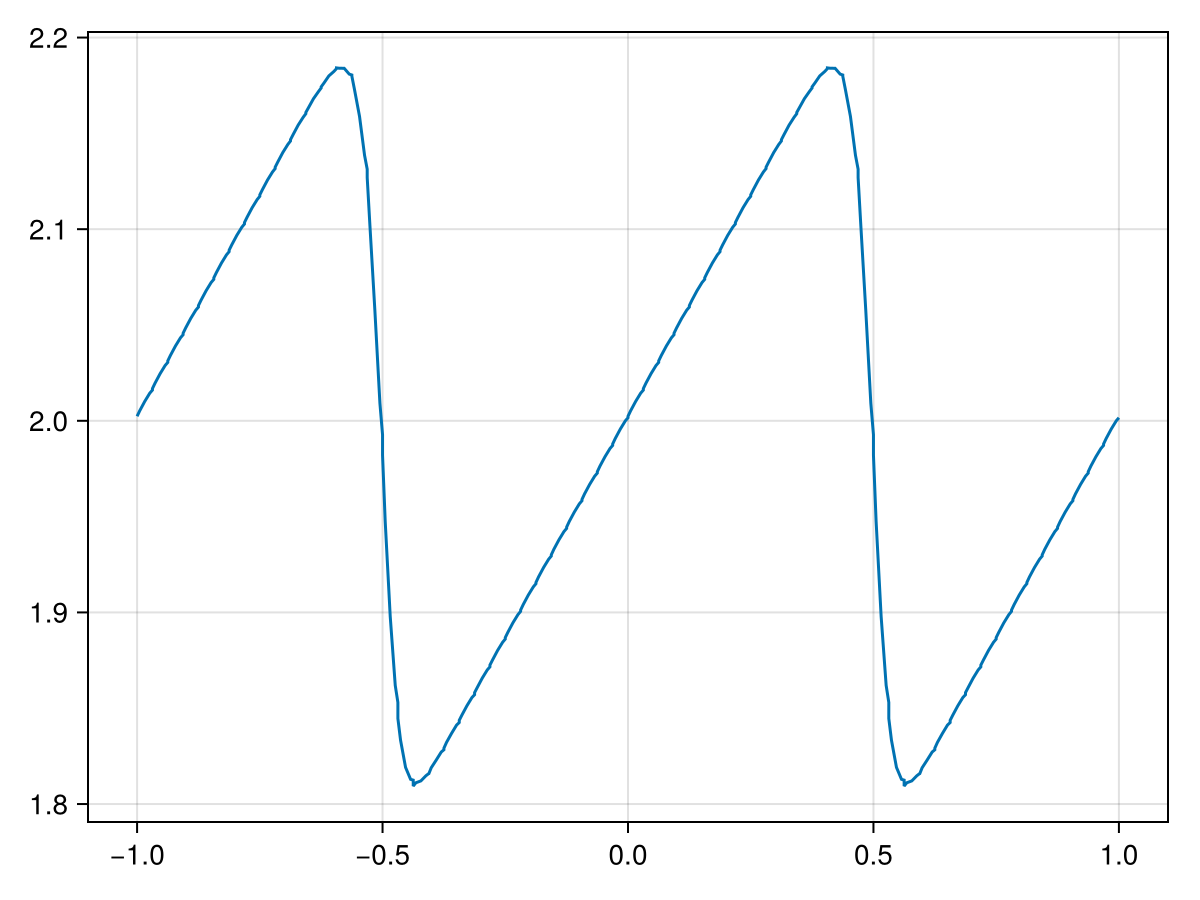

In [76]:
lines(vec(x), sol(2.0))